In [ ]:
import sys
sys.path.append('../')
import torch 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
from utils.dataset import Test_Segmentation_CustomDataset as Test_CustomDataset
import os
from utils.__init__ import *
from utils import * 
from utils.metrics import calculate_metrics
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys 
sys.path.append('../')
from model import load_model 
from model import * 

In [ ]:
vl_img_dir = '/mnt/HDD/chest-seg/dataset1000/test/img' 
vl_mask_dir = '/mnt/HDD/chest-seg/dataset1000/test/mask' 
ts_img_dir = '/mnt/HDD/chest-seg/dataset1000/extra/img'

transform = {
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

# Dataset and DataLoader setup
valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transform['valid'],
    testing=True,
)

test_dataset = Test_CustomDataset(
    image_dir = ts_img_dir,
    transform=transform['test'],
)
vl_batch, ts_batch = 4,4
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = ts_batch, shuffle = True)
for images, masks, paths in valid_loader:
    print(images.shape, masks.shape)
    print(f'image range : {images.unique()[0]}~{images.unique()[-1]}')
    print(f'mask range : {masks.unique()[0]}~{masks.unique()[-1]}')
    train_plotting(images, masks)
    break

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

checkpoint_save_path = '/mnt/HDD/chest-seg_models/monai_swinunet_v7_240519/model_1552.pt'

model_save_path = os.path.dirname(checkpoint_save_path)
model_version = checkpoint_save_path.split('/')[-1]

# model_name= 'monai_swinunet'` is a commented-out line of code. This means that it is not currently being executed as part of the program. It appears to be a previous assignment of the variable `model_name` to the value `'monai_swinunet'`, but it has been commented out and is not active in the current code execution.
# model_name = checkpoint_save_path.split('/')[-2].split('_')[0]
# model_name= 'unet_plus_plus'
model_name= 'monai_swinunet'

metric_save_path = os.path.join('/mnt/HDD/chest-seg_models/results', checkpoint_save_path.split('/')[-2]+'.csv')
valid_save_dir = os.path.join(model_save_path, 'valid')
test_save_dir = os.path.join(model_save_path, 'test')
os.makedirs(valid_save_dir, exist_ok=True)
os.makedirs(test_save_dir, exist_ok=True)
print(f" Model save path : {model_save_path}")
print(f" Model version : {model_version}")
print(f" Model name : {model_name}")
print(f" Valid save path : {valid_save_dir}")
print(f" Test save path : {test_save_dir}")

# weight load 
checkpoint = torch.load(os.path.join(model_save_path, model_version), map_location= device)['model_state_dict']

model_loader = load_model.segmentation_models_loader(model_name = model_name)
model = model_loader().to(device)
model.load_state_dict(checkpoint)
# model weight에서 dead weight 파라미터 개수 확인 
model_dead_weight(model = model)
            
test_metrics = {'Accuracy': [], 'mIoU':[], 'Dice':[], 'Hausdorff' : []}

print(f'output shape : {model(torch.randn(vl_batch, 1, 224, 224).to(device)).shape}')

## Valid

In [ ]:
# Initialize variables
threshold = 0.5 # Commonly used threshold for binary classification
valid_accs, valid_ious, valid_dices, valid_hds = 0, 0, 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    model.eval()
    for images, masks, paths in valid_loader:
        images, masks = images.to(device), masks.to(device)
        # Inference
        outputs = model(images)  # input image
        preds = torch.sigmoid(outputs)

        iou, acc, dice, hd = calculate_metrics(preds, masks, threshold=threshold)
        valid_ious += iou
        valid_accs += acc
        valid_dices += dice
        valid_hds += hd
        # save_prediction(preds, threshold = threshold, paths = paths, save_dir = valid_save_dir)
        # break
    test_metrics['Accuracy'].append(valid_accs/len(valid_loader))
    test_metrics['mIoU'].append(valid_ious/len(valid_loader))
    test_metrics['Dice'].append(valid_dices/len(valid_loader))
    test_metrics['Hausdorff'].append(valid_hds/len(valid_loader))
    save_metrics(test_metrics, save_path = metric_save_path)
    print(f'image range : {images.unique()[0]}~{images.unique()[-1]}')
    print(f'mask range : {masks.unique()[0]}~{masks.unique()[-1]}')
    print(f'preds range : {preds[0,0].min()}~{preds[0,0].max()}')
    print(f'Valid Acc : {valid_accs/len(valid_loader)}')
    print(f'Valid IoU : {valid_ious/len(valid_loader)}')
    print(f'Valid Dice : {valid_dices/len(valid_loader)}')
    print(f'Valid HD : {valid_hds/len(valid_loader)}')
    
    for i in range(len(images)):
        plt.figure(dpi=128)
        plt.subplot(131)
        plt.imshow(images[i, 0].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(masks[i, 0].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(133)
        plt.imshow((preds[i, 0]>threshold).float().cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        plt.close()

## Test (no masking data)

In [ ]:
threshold = 0.5
with torch.no_grad():
    model.eval()
    for images, paths in test_loader:
        images = images.to(device)
        # Inference
        outputs = model(images)  # input image
        preds = torch.sigmoid(outputs)
        
        save_prediction(preds, threshold = threshold, paths = paths, save_dir = test_save_dir)
        break 
    # Mask and output mask plot
    for i in range(len(images)):
        plt.figure(dpi=128)
        plt.subplot(121)
        plt.imshow(images[i, 0].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow((preds[i, 0]>threshold).float().cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        plt.close()

# result metric 비교

In [3]:
metric_dir = '/mnt/HDD/chest-seg_models/results'
import os
import pandas as pd 
import matplotlib.pyplot as plt
# Load metrics
metrics_path = [os.path.join(metric_dir, path) for path in os.listdir(metric_dir)]
# 모델명 추출
model_name = [path.split('/')[-1].split('.')[0] for path in metrics_path]

# csv파일 load하면서 모델명과 함께 변수로 저장
total_df = pd.DataFrame()
for path in metrics_path:
    # index 없이 csv파일 load
    if 'total' in path:
        continue
    
    df = pd.read_csv(path)
    # df에 모델명 가장 첫번쨰 칼럼으로 추가
    df.insert(0, 'Model', path.split('/')[-1].split('.')[0])
    
    # total_df에 df 추가
    total_df = pd.concat([total_df, df], axis=0)
# total_df에 index reset
total_df.reset_index(drop=True, inplace=True)

# accuracy 기준으로 내림차순 정렬
total_df = total_df.sort_values(by='Dice', ascending=False)

# 저장하기
total_df.to_csv('/mnt/HDD/chest-seg_models/results/total_metrics.csv', index=False) 
total_df


,Model,Accuracy,mIoU,Dice,Hausdorff
0,monai_swinunet_v8_240519,0.901926,0.711518,0.834417,4.340451
10,monai_swinunet_v7_240519,0.897492,0.684808,0.814022,4.466291
6,monai_swinunet_v12_240521,0.888216,0.668047,0.805995,4.610856
1,monai_swinunet_v11_240520,0.856717,0.633515,0.782908,4.956256
8,monai_swinunet_v10_240519,0.770237,0.428888,0.605630,5.302510
5,monai_swinunet_v9_240519,0.747164,0.389101,0.569280,5.433020
9,unet_v8_240520,0.661754,0.318290,0.473693,5.945132
14,unet_plus_plus_v8_240520,0.656831,0.306996,0.459855,5.803564
11,swinunet_v7_240519,0.595802,0.165747,0.289498,6.114659
13,manet_v7_240519,0.586247,0.171493,0.263871,5.843361


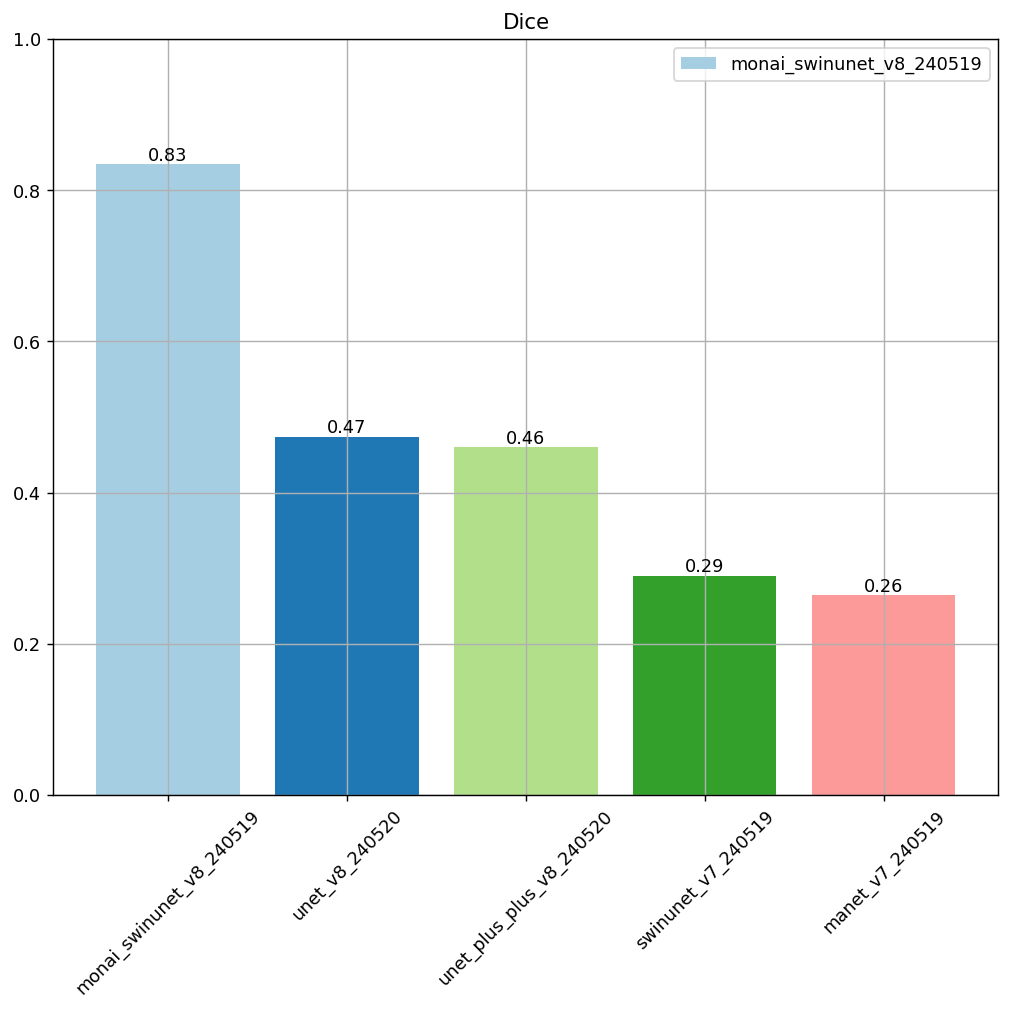

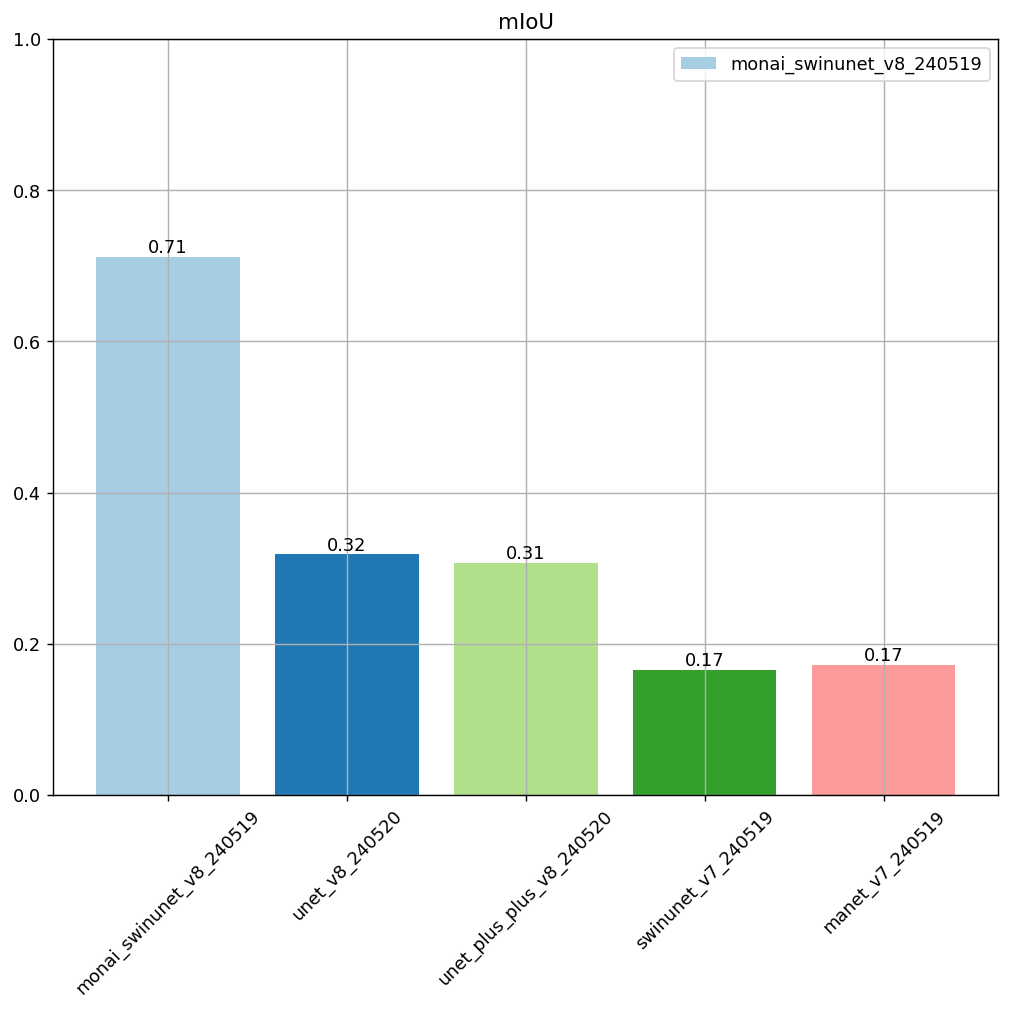

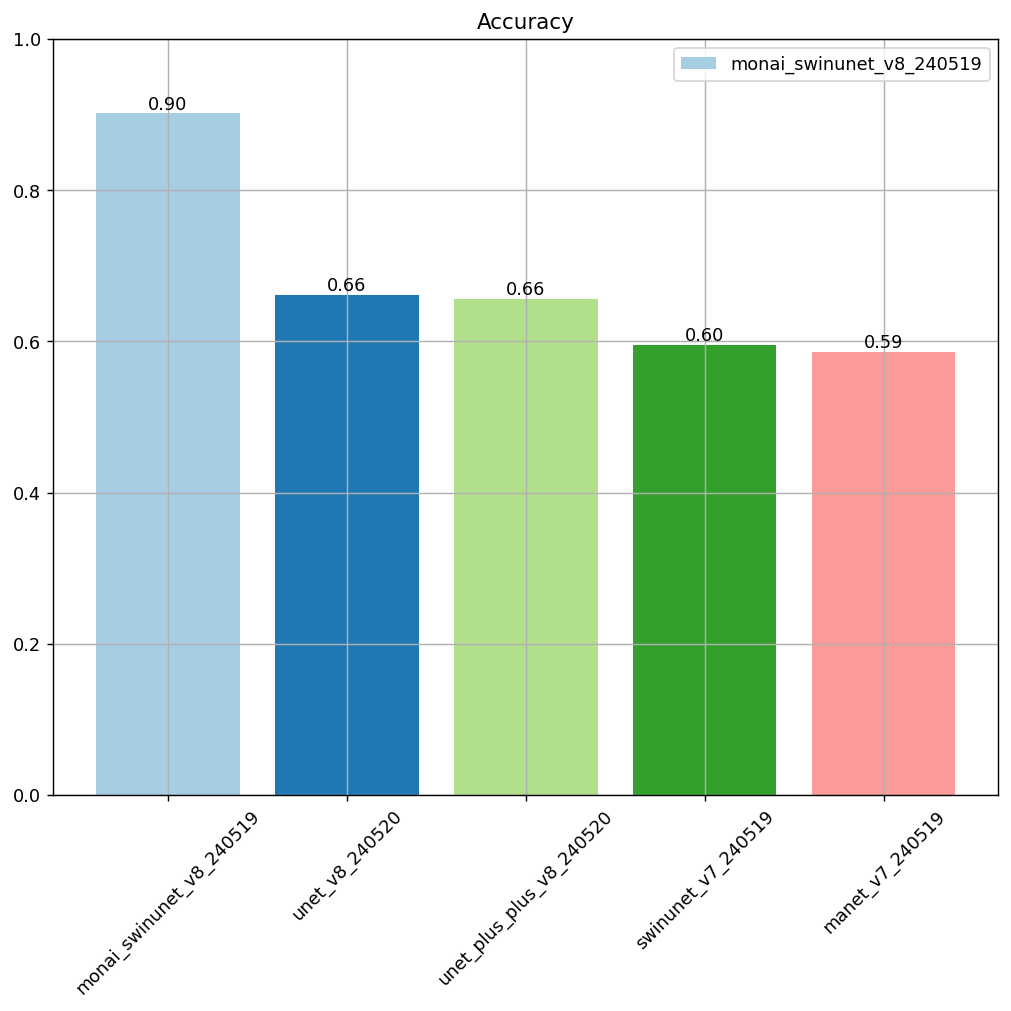

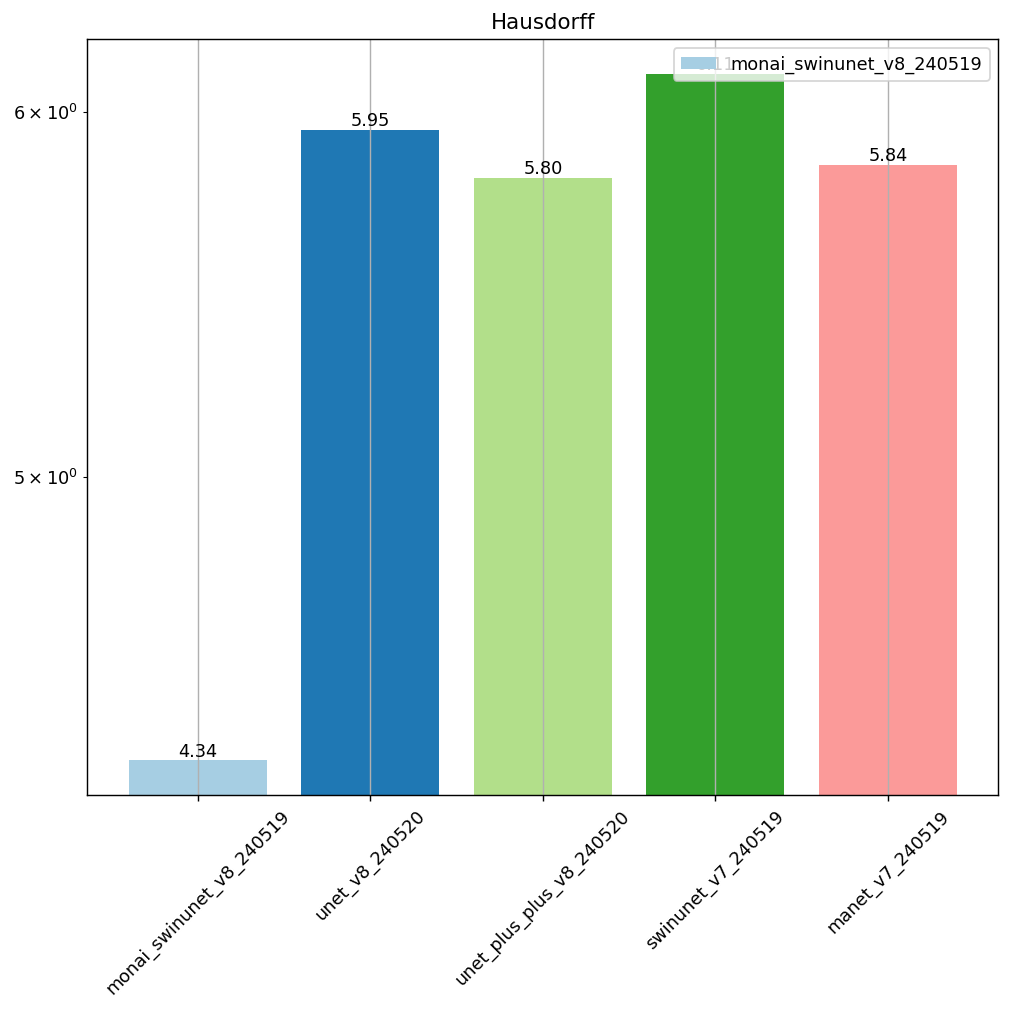

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt

# load 
total_df = pd.read_csv('/mnt/HDD/chest-seg_models/results/total_metrics.csv')
metrics = ['Dice', 'mIoU', 'Accuracy', 'Hausdorff']
# 상위 5개만 추출
total_df = total_df.head(5)


# metric별 상위 5개 모델 비교
for i, metric in enumerate(metrics):
    plt.figure(dpi=128, figsize = (8, 8))
    plt.subplot(111)
    plt.bar(total_df['Model'], total_df[metric])
    plt.title(f'{metric}')
    plt.xticks(rotation=45)
    if metric == 'Hausdorff':
        plt.yscale('log')
    else:
        plt.ylim(0, 1)
    plt.grid()

    # bar위에 값 표시 소수점 2자리까지
    for idx, value in enumerate(total_df[metric]):
        plt.text(idx, value, f'{value:.2f}', ha='center', va='bottom')    
    
    # bar 마다 색깔 다르게 하기 : 색상은 연한파스텔 톤으로 
    colors = plt.cm.Paired(range(len(total_df)))
    for i, bar in enumerate(plt.gca().patches):
        bar.set_facecolor(colors[i])
        plt.legend(total_df['Model'], loc='upper right')
    
    # legend bar마다 색상에 매칭해서 표시해주기
    
    plt.tight_layout()

    plt.show()
    plt.close()
    
    

    

In [ ]:
ignite.utils.